# 항공이미지 분류

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os
import gc
import random
from tqdm.notebook import tqdm

import torch
import torchvision.transforms as T

import timm

from sklearn.metrics import f1_score

In [2]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

device = 'mps'

# Data 확인

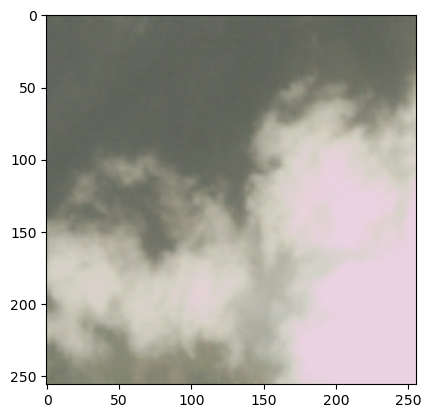

In [3]:
cloudy_img = cv2.imread('/Users/kimhongseok/cv_79_projects/part2/8/data/train/cloudy/train_12.jpg')
cloudy_img = cv2.cvtColor(cloudy_img, cv2.COLOR_BGR2RGB)
plt.imshow(cloudy_img)
plt.show()

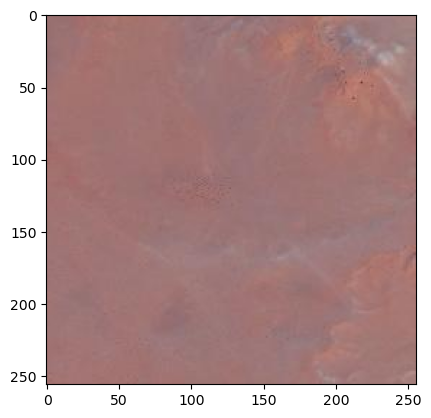

In [4]:
dessert_img = cv2.imread('/Users/kimhongseok/cv_79_projects/part2/8/data/train/desert/desert(1).jpg')
dessert_img = cv2.cvtColor(dessert_img, cv2.COLOR_BGR2RGB)
plt.imshow(dessert_img)
plt.show()

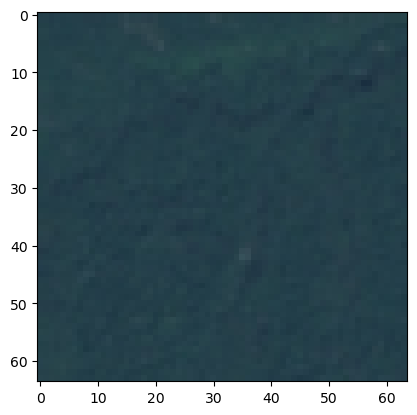

In [5]:
green_img = cv2.imread('/Users/kimhongseok/cv_79_projects/part2/8/data/train/green_area/Forest_2.jpg')
green_img = cv2.cvtColor(green_img, cv2.COLOR_BGR2RGB)
plt.imshow(green_img)
plt.show()

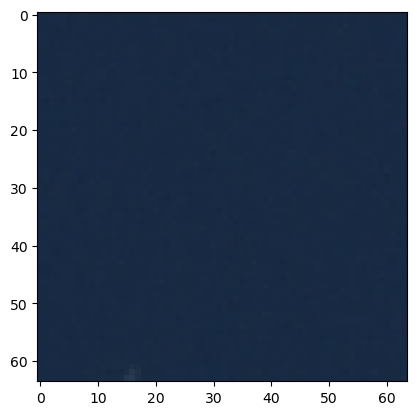

In [6]:
water_img = cv2.imread('/Users/kimhongseok/cv_79_projects/part2/8/data/train/water/SeaLake_1.jpg')
water_img = cv2.cvtColor(water_img, cv2.COLOR_BGR2RGB)
plt.imshow(water_img)
plt.show()

# Custom Dataset

In [7]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_path, classes, transforms):
        super().__init__()
        self.data = []
        self.transforms = transforms

        for i, cls in enumerate(classes):
            if cls != '.DS_Store':
                cls_path = os.path.join(root_path, cls)
                img_list = os.listdir(cls_path)

                for img in img_list:
                    if img != '.DS_Store':
                        img_path = os.path.join(cls_path, img)
                        self.data.append((img_path, i))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx][0]).convert('RGB')
        img = self.transforms(img)
        label = self.data[idx][1]

        return img, label

In [8]:
transforms = T.Compose([
    T.ToTensor(),
    T.Resize((64, 64))
])
classes = os.listdir('/Users/kimhongseok/cv_79_projects/part2/8/data/train')

train_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part2/8/data/train', classes, transforms)
valid_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part2/8/data/val', classes, transforms)
test_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part2/8/data/test', classes, transforms)

/opt/anaconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


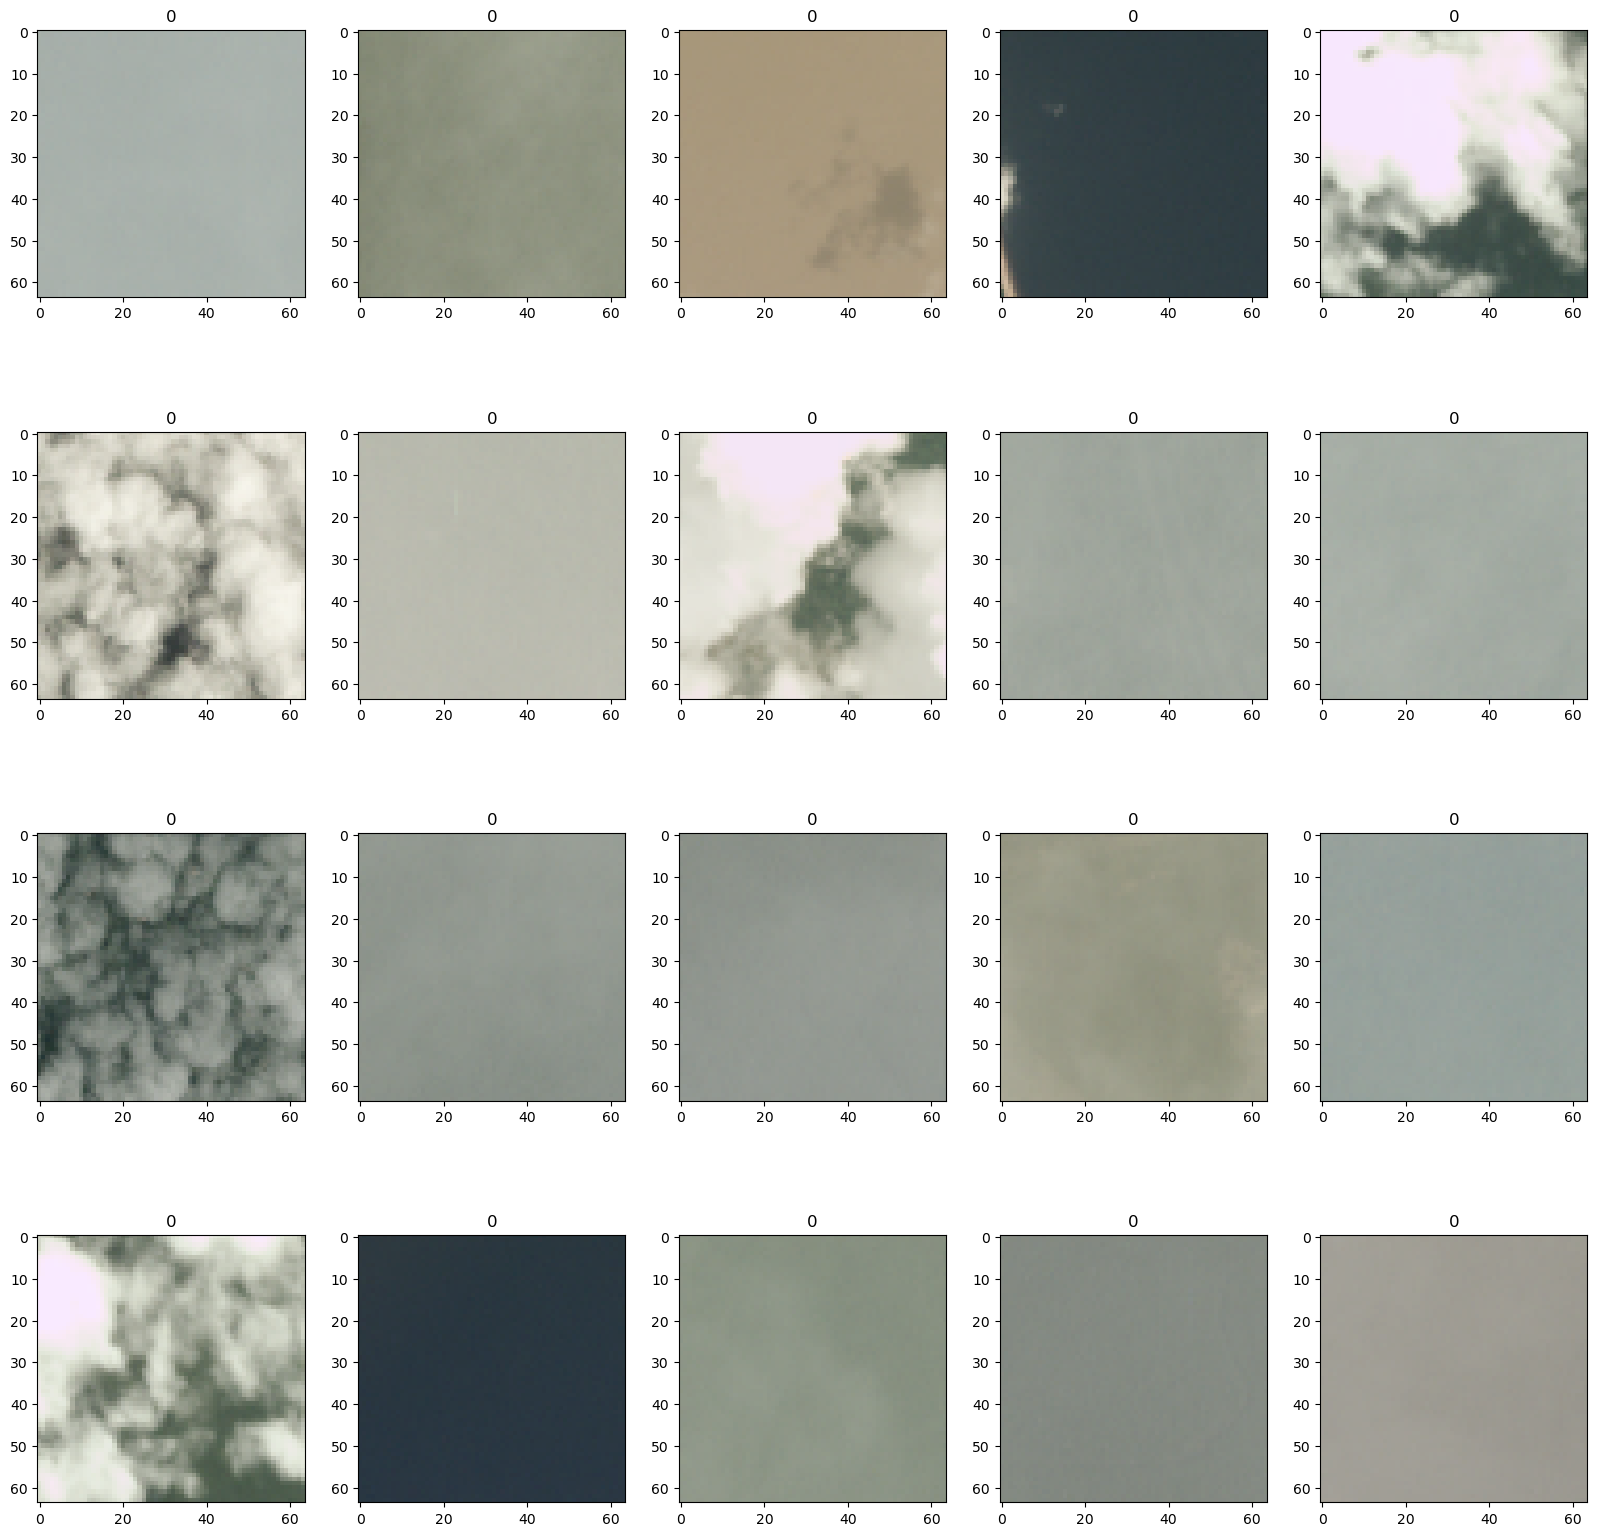

In [9]:
plt.figure(figsize=(20, 20))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(train_dataset[i][0].permute(1, 2, 0))
    plt.title(train_dataset[i][1])

In [10]:
print(len(train_dataset), len(valid_dataset), len(test_dataset))

4549 646 398


In [11]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# train, eval

In [12]:
def training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        max_prob, preds = torch.max(probs, 1)
        train_accuracy += (preds == labels).sum().item()

        tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}')

    train_loss /= len(train_dataloader)
    train_accuracy /= len(train_dataset)

    return model, train_loss, train_accuracy

def evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs):
    model.eval()
    valid_loss = 0.0
    valid_accuracy = 0

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            max_prob, preds = torch.max(probs, 1)
            valid_accuracy += (preds==labels).sum().item()

            tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Valid Loss: {loss.item():.4f}')

    valid_loss /= len(valid_dataloader)
    valid_accuracy /= len(valid_dataset)

    return model, valid_loss, valid_accuracy

def training_loop(model, train_dataloader, valid_dataloade, train_dataset, valid_dataset, criterion, optimizer, num_epochs):
    model.to(device)

    for epoch in range(num_epochs):
        model, train_loss, train_accuracy = training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs)
        model, valid_loss, valid_accuracy = evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs)

        print(f'Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Valid Loss: {valid_loss}, Valid Accuracy: {valid_accuracy}')

    return model

# model

In [13]:
model = timm.create_model(
    'resnet18',
    pretrained=True,
    num_classes=len(classes)-1
)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [14]:
for params in model.parameters():
    params.require_grad = False

for params in model.fc.parameters():
    params.require_grad = True

In [15]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, 10)

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.1772226092741928, Train Accuracy: 0.7724774675752912, Valid Loss: 0.022443818669258195, Valid Accuracy: 0.6857585139318886


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.0440724230688324, Train Accuracy: 0.8122664321828973, Valid Loss: 0.07534630895084278, Valid Accuracy: 0.6671826625386997


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.03765573841256911, Train Accuracy: 0.8100681468454606, Valid Loss: 0.012976462169635024, Valid Accuracy: 0.6826625386996904


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.054626599620355085, Train Accuracy: 0.8151242031215652, Valid Loss: 0.016829665580933743, Valid Accuracy: 0.6873065015479877


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.0503161398454621, Train Accuracy: 0.8076500329742801, Valid Loss: 0.06001649255102331, Valid Accuracy: 0.6625386996904025


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.03590937511600916, Train Accuracy: 0.8162233457902835, Valid Loss: 0.043872148475863716, Valid Accuracy: 0.6780185758513931


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.09711210710358703, Train Accuracy: 0.7986370630907892, Valid Loss: 0.7823080711532384, Valid Accuracy: 0.5309597523219814


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.04866327428317163, Train Accuracy: 0.8120466036491537, Valid Loss: 0.01544369682034647, Valid Accuracy: 0.6826625386996904


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.048777838677374855, Train Accuracy: 0.8094086612442295, Valid Loss: 0.05057777542705563, Valid Accuracy: 0.6718266253869969


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.039443239106832256, Train Accuracy: 0.8107276324466915, Valid Loss: 0.01578439822928472, Valid Accuracy: 0.6857585139318886


# test

In [20]:
model.eval()
total_preds = []
total_labels = []

with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(probs, 1)
        total_preds.extend(preds.cpu().numpy())
        total_labels.extend(labels.cpu().numpy())

  0%|          | 0/7 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_49489/4137234194.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = torch.nn.functional.softmax(outputs)


In [22]:
f1_score(total_labels, total_preds, average='macro')

0.6714618312827136